In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_DIR = '/kaggle/working/'
DATA_DIR = '/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images'
BATCH_SIZE = 64
EPOCHS_BYOL = 50
EPOCHS_LINEAR = 2
NUM_CLASSES = 2
print(f"Using device: {DEVICE}")


Using device: cuda


In [4]:
class BYOLTransform:
    def __init__(self, size=224):
        self.transform = T.Compose([
            T.RandomResizedCrop(size),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.GaussianBlur(kernel_size=3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

# BYOL dataset
class ContrastiveDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.dataset = ImageFolder(root=root)
        self.transform = transform

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        return self.transform(img)

    def __len__(self):
        return len(self.dataset)

In [5]:
train_dataset = ContrastiveDataset(
    root=os.path.join(DATA_DIR),
    transform=BYOLTransform(size=224)
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [6]:
class Encoder(nn.Module):
    def __init__(self, feature_dim=256):
        super().__init__()
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, feature_dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = F.normalize(self.fc(x), dim=1)
        return x


In [7]:
class MLPHead(nn.Module):
    def __init__(self, in_dim, out_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.BatchNorm1d(in_dim),
            nn.ReLU(inplace=True),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [8]:
class BYOL(nn.Module):
    def __init__(self, encoder, projection_dim=256):
        super().__init__()
        self.encoder = encoder
        self.projector = MLPHead(encoder.fc.out_features, projection_dim)
        self.predictor = MLPHead(projection_dim, projection_dim)

    def forward(self, x1, x2):
        proj1_online = self.predictor(self.projector(self.encoder(x1)))
        proj2_online = self.predictor(self.projector(self.encoder(x2)))
        return proj1_online, proj2_online

    def encode_only(self, x):
        return self.encoder(x)


In [9]:
def loss_fn(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return 2 - 2 * (x * y).sum(dim=-1).mean()

def update_moving_average(online_net, target_net, beta):
    for param_q, param_k in zip(online_net.parameters(), target_net.parameters()):
        param_k.data = param_k.data * beta + param_q.data * (1. - beta)


In [10]:
online_encoder = BYOL(Encoder()).to(DEVICE)
target_encoder = BYOL(Encoder()).to(DEVICE)
target_encoder.load_state_dict(online_encoder.state_dict())

optimizer = optim.Adam(online_encoder.parameters(), lr=3e-4)
beta = 0.99
byol_loss_history = []

for epoch in range(1, EPOCHS_BYOL + 1):
    online_encoder.train()
    total_loss = 0

    for (view1, view2) in tqdm(train_loader, desc=f"BYOL Epoch {epoch}"):
        view1, view2 = view1.to(DEVICE), view2.to(DEVICE)

        proj1_online, proj2_online = online_encoder(view1, view2)

        with torch.no_grad():
            proj1_target, proj2_target = target_encoder(view1, view2)
            proj1_target = proj1_target.detach()
            proj2_target = proj2_target.detach()

        loss = loss_fn(proj1_online, proj2_target) + loss_fn(proj2_online, proj1_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        update_moving_average(online_encoder, target_encoder, beta)

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    byol_loss_history.append(avg_loss)
    print(f"Epoch {epoch}/{EPOCHS_BYOL} - Loss: {avg_loss:.4f}")

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
BYOL Epoch 1: 100%|██████████| 50/50 [00:46<00:00,  1.06it/s]


Epoch 1/50 - Loss: 1.0672


BYOL Epoch 2: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 2/50 - Loss: 0.2803


BYOL Epoch 3: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 3/50 - Loss: 0.1113


BYOL Epoch 4: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch 4/50 - Loss: 0.0555


BYOL Epoch 5: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 5/50 - Loss: 0.0308


BYOL Epoch 6: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 6/50 - Loss: 0.0198


BYOL Epoch 7: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 7/50 - Loss: 0.0149


BYOL Epoch 8: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 8/50 - Loss: 0.0110


BYOL Epoch 9: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 9/50 - Loss: 0.0087


BYOL Epoch 10: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 10/50 - Loss: 0.0066


BYOL Epoch 11: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 11/50 - Loss: 0.0059


BYOL Epoch 12: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 12/50 - Loss: 0.0045


BYOL Epoch 13: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 13/50 - Loss: 0.0039


BYOL Epoch 14: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 14/50 - Loss: 0.0033


BYOL Epoch 15: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 15/50 - Loss: 0.0026


BYOL Epoch 16: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 16/50 - Loss: 0.0022


BYOL Epoch 17: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 17/50 - Loss: 0.0020


BYOL Epoch 18: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch 18/50 - Loss: 0.0017


BYOL Epoch 19: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 19/50 - Loss: 0.0014


BYOL Epoch 20: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 20/50 - Loss: 0.0012


BYOL Epoch 21: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 21/50 - Loss: 0.0011


BYOL Epoch 22: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch 22/50 - Loss: 0.0010


BYOL Epoch 23: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 23/50 - Loss: 0.0008


BYOL Epoch 24: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 24/50 - Loss: 0.0008


BYOL Epoch 25: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


Epoch 25/50 - Loss: 0.0007


BYOL Epoch 26: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 26/50 - Loss: 0.0006


BYOL Epoch 27: 100%|██████████| 50/50 [00:44<00:00,  1.11it/s]


Epoch 27/50 - Loss: 0.0005


BYOL Epoch 28: 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


Epoch 28/50 - Loss: 0.0005


BYOL Epoch 29: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Epoch 29/50 - Loss: 0.0004


BYOL Epoch 30: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 30/50 - Loss: 0.0004


BYOL Epoch 31: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 31/50 - Loss: 0.0003


BYOL Epoch 32: 100%|██████████| 50/50 [00:45<00:00,  1.10it/s]


Epoch 32/50 - Loss: 0.0003


BYOL Epoch 33: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Epoch 33/50 - Loss: 0.0003


BYOL Epoch 34: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Epoch 34/50 - Loss: 0.0003


BYOL Epoch 35: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Epoch 35/50 - Loss: 0.0002


BYOL Epoch 36: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Epoch 36/50 - Loss: 0.0002


BYOL Epoch 37: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 37/50 - Loss: 0.0002


BYOL Epoch 38: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 38/50 - Loss: 0.0002


BYOL Epoch 39: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Epoch 39/50 - Loss: 0.0002


BYOL Epoch 40: 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


Epoch 40/50 - Loss: 0.0002


BYOL Epoch 41: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 41/50 - Loss: 0.0001


BYOL Epoch 42: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 42/50 - Loss: 0.0001


BYOL Epoch 43: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 43/50 - Loss: 0.0001


BYOL Epoch 44: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Epoch 44/50 - Loss: 0.0001


BYOL Epoch 45: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 45/50 - Loss: 0.0001


BYOL Epoch 46: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 46/50 - Loss: 0.0001


BYOL Epoch 47: 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]


Epoch 47/50 - Loss: 0.0001


BYOL Epoch 48: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 48/50 - Loss: 0.0001


BYOL Epoch 49: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 49/50 - Loss: 0.0001


BYOL Epoch 50: 100%|██████████| 50/50 [00:43<00:00,  1.14it/s]

Epoch 50/50 - Loss: 0.0001


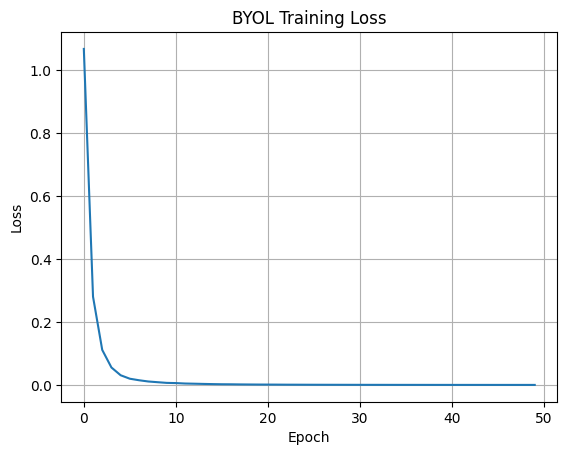

In [11]:
plt.plot(byol_loss_history)
plt.title('BYOL Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Save encoder weights
torch.save(online_encoder.encoder.state_dict(), os.path.join(SAVE_DIR, 'byol_encoder_monkeypox.pth'))